In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import sklearn
import data_process
import define_model
import model_evaluation
from matplotlib import cm
from torch.utils.data import DataLoader
import pointcloud_loader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [21]:
import EPiC_models

def count_sig(y):
    # y has 2 columns
    ysig=y[:, 0]
    sig_num = len(ysig[ysig==1])
    return sig_num

def data_vs_bg_label(x, y, sig_num, len_train):
    x_sig = []
    x_bg = []
    count = 0
    for i in y:
        if i == 1:
            x_sig.append(x[count])
            count += 1
        else:
            x_bg.append(x[count])
            count += 1 
    x_data = np.concatenate((x_sig[:sig_num], x_bg[:(60000 - sig_num)]), axis = 0)
    x_bg_bg = x_bg[60001 - sig_num: len_train - sig_num]
    y_data = np.ones((len(x_data), 1))
    y_bg = np.zeros((len(x_bg_bg), 1))
    new_x = np.concatenate((x_data, x_bg_bg), axis=0)
    new_y = np.concatenate((y_data, y_bg), axis=0)
    return new_x, new_y

def evaluate_median_output(device, dir=None, l1=64, l2=64, l3=64, gauss_num=0, S_over_B="", signal_vs_bg=False, uniform_num=0, phi=False, duplicate_feature=0, dropout=False, morelayers=False):
    print("From " + dir)
    # define parameters
    if phi:
        X_test = np.load("data/X_files/X_test_phi.npy")
        y_test = np.load("data/X_files/y_test_phi.npy")
    elif uniform_num>0:
        X_test = np.load("data/X_files/X_test_uni.npy")
        y_test = np.load("data/X_files/y_test_uni.npy")
        X_test = X_test[:, :4 + uniform_num]
    else:
        if signal_vs_bg:
            X_train = np.load("data/X_files/X_train_sb"+S_over_B+".npy")
            print("Fully supervised")
        else:
            X_train = np.load("data/X_files/X_train"+S_over_B+".npy")
            print("Idealized AD")
        pre_X_test = np.load("data/X_files/X_test.npy")
        y_test = np.load("data/X_files/y_test.npy")
        X_test = data_process.data_normalize(pre_X_test, X_train)
        X_test = X_test[:, :4 + gauss_num]
    
    X_test = torch.from_numpy(X_test).float().to(device)
    test_data = data_process.MakeASet(X_test, y_test)
    test_loader = DataLoader(dataset=test_data, batch_size=256, shuffle=False)
    input_number = len(X_test[0])
    pred_median = []
    # 10 models
    for model_num in range(10):
        # defining new NN every change of model
        model = define_model.NeuralNetwork(input_number, l1, l2, l3).to(device)

        collect_pred = []

        val_losses = np.load("saved_model/"+dir+"val_losses_model_"+str(model_num+1)+".npy")

        model_number = model_evaluation.choose_ten_best(val_losses)

        # collect val values for median on legends
        val_list = [] # for mean of val losses to pass to collect_val
        for val in model_number:
            val_list.append(val_losses[val])

        # 10 epochs
        for i in model_number:
            model.load_state_dict(torch.load("saved_model/"+dir+"saved_training_model"+str(model_num+1)+'_epoch'+str(i+1)+".pt"))

            # Evaluation
            model.eval()
            with torch.no_grad():
                # signal vs bg
                for batch, (X, y) in enumerate(test_loader):
                    test_pred = model(X)
                    collect_pred.append(test_pred.cpu().numpy())
        collect_pred = np.vstack(collect_pred)
        collect_pred = np.resize(collect_pred, (10, len(y_test), 1))
        collect_pred = np.mean(collect_pred, axis = 0)
        pred_median.append(collect_pred)
    pred_median = np.median(pred_median, axis=0)
    pred_median = np.resize(pred_median, (len(pred_median), 1))
    pred_median = np.concatenate((pred_median, y_test), axis=1)
    return pred_median

def evaluate_median_output_EPiC(device, dir=None, S_over_B="", signal_vs_bg=False):
    print("From " + dir)
    # define parameters
    if signal_vs_bg:
        X_train = np.load("data/X_files_EPiC/X_train_sb"+S_over_B+".npy")
        y_train = np.load("data/X_files_EPiC/y_train_sb"+S_over_B+".npy")

        X_val = np.load("data/X_files_EPiC/X_val_sb"+S_over_B+".npy")
        y_val = np.load("data/X_files_EPiC/y_val_sb"+S_over_B+".npy")
        print("Fully supervised")
    else:
        X_train = np.load("data/X_files_EPiC/X_train"+S_over_B+".npy")
        y_train = np.load("data/X_files_EPiC/y_train"+S_over_B+".npy")

        X_val = np.load("data/X_files_EPiC/X_val"+S_over_B+".npy")
        y_val = np.load("data/X_files_EPiC/y_val"+S_over_B+".npy")
        print("Idealized AD")
    sig_num = count_sig(y_train)
    X_test = np.load("data/X_files_EPiC/X_test.npy")
    y_test = np.load("data/X_files_EPiC/y_test.npy")

    X_db, y_db = data_vs_bg_label(X_test, y_test, sig_num, len(y_train))
    print(np.shape(y_val))
    print(np.shape(y_db))

    X_val = torch.from_numpy(X_val).float().to(device)
    X_db = torch.from_numpy(X_db).float().to(device)

    input_number = len(X_test[0,0])
    train_data = pointcloud_loader.PointCloudDataset_ZeroPadded(X_train, y_train)
    val_data = pointcloud_loader.PointCloudDataset_ZeroPadded(X_val, y_val)
    db_data = pointcloud_loader.PointCloudDataset_ZeroPadded(X_db, y_db)
    mean, std = train_data.get_means_stds()

    val_loader = DataLoader(dataset=val_data, batch_size=128, shuffle=True)
    db_loader = DataLoader(dataset=db_data, batch_size=128, shuffle=True)
    
    pred_median_val = []
    pred_median_test = []
    # 10 models
    for model_num in range(1):
        # defining new NN every change of model
        model = EPiC_models.EPiC_discriminator_mask(input_number).to(device)
        
        collect_pred_val = []
        collect_pred_test = []

        val_losses = np.load("saved_model/"+dir+"val_losses_model_"+str(model_num+1)+".npy")

        model_number = model_evaluation.choose_ten_best(val_losses)

        # collect val values for median on legends
        val_list = [] # for mean of val losses to pass to collect_val
        for val in model_number:
            val_list.append(val_losses[val])

        # 10 epochs
        for i in model_number:
            model.load_state_dict(torch.load("saved_model/"+dir+"saved_training_model"+str(model_num+1)+'_epoch'+str(i+1)+".pt"))
            model.eval()
            with torch.no_grad():
            # Validation
                for batch, (X, y) in enumerate(val_loader):
                    mask = (X[...,0] != 0.)
                    mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
                    X = data_process.data_normalize_EPiC(X, mean, std)
                    val_pred = model(X, mask)
                    collect_pred_val.append(val_pred.cpu().numpy())
            # Evaluation
                for batch, (X, y) in enumerate(db_loader):
                    mask = (X[...,0] != 0.)
                    mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
                    X = data_process.data_normalize_EPiC(X, mean, std)
                    test_pred = model(X, mask)
                    collect_pred_test.append(test_pred.cpu().numpy())
        collect_pred_val = np.vstack(collect_pred_val)
        collect_pred_val = np.resize(collect_pred_val, (10, len(y_val), 1))
        collect_pred_val = np.mean(collect_pred_val, axis = 0)
        pred_median_val.append(collect_pred_val)

        collect_pred_test = np.vstack(collect_pred_test)
        collect_pred_test = np.resize(collect_pred_test, (10, len(y_db), 1))
        collect_pred_test = np.mean(collect_pred_test, axis = 0)
        pred_median_test.append(collect_pred_test)

    pred_median_val = np.median(pred_median_val, axis=0)
    pred_median_val = np.resize(pred_median_val, (len(pred_median_val), 1))
    pred_median_val = np.concatenate((pred_median_val, y_val), axis=1)

    pred_median_test = np.median(pred_median_test, axis=0)
    pred_median_test = np.resize(pred_median_test, (len(pred_median_test), 1))
    pred_median_test = np.concatenate((pred_median_test, y_db), axis=1)
    return pred_median_val, pred_median_test

From EPiC/
Idealized AD
(196428, 2)
(196427, 1)


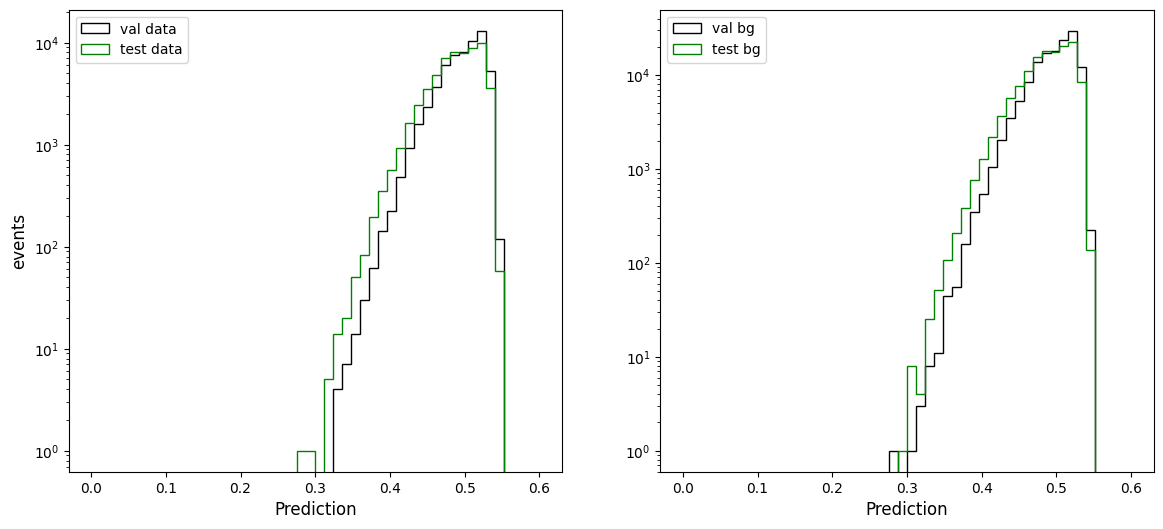

In [22]:
val_sig = []
val_bg = []
test_sig = []
test_bg = []
# pred = evaluate_median_output(device=device, dir=method+task+"/", gauss_num=gauss)
pred_val, pred_test = evaluate_median_output_EPiC(device=device, dir="EPiC/")
for i in range(len(pred_val)):
    if pred_val[i,2]==1:
        val_sig.append(pred_val[i,0])
    else:
        val_bg.append(pred_val[i,0])
val_sig = np.stack(val_sig)
val_bg = np.stack(val_bg)

for i in range(len(pred_test)):
    if pred_test[i,1]==1:
        test_sig.append(pred_test[i,0])
    else:
        test_bg.append(pred_test[i,0])
test_sig = np.stack(test_sig)
test_bg = np.stack(test_bg)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.hist(val_sig, label="val data", bins=50, range=(0, 0.6), histtype="step", stacked=True, color="black")
ax1.hist(test_sig, label="test data", bins=50, range=(0, 0.6), histtype="step", stacked=True, color="green")
ax2.hist(val_bg, label="val bg", bins=50, range=(0, 0.6), histtype="step", stacked=True, color="black")
ax2.hist(test_bg, label="test bg", bins=50, range=(0, 0.6), histtype="step", stacked=True, color="green")
ax1.set_xlabel("Prediction", fontsize=12)
ax2.set_xlabel("Prediction", fontsize=12)
ax1.set_ylabel("events", fontsize=12)
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
plt.show()
plt.close()

From EPiC/
Idealized AD


KeyboardInterrupt: 

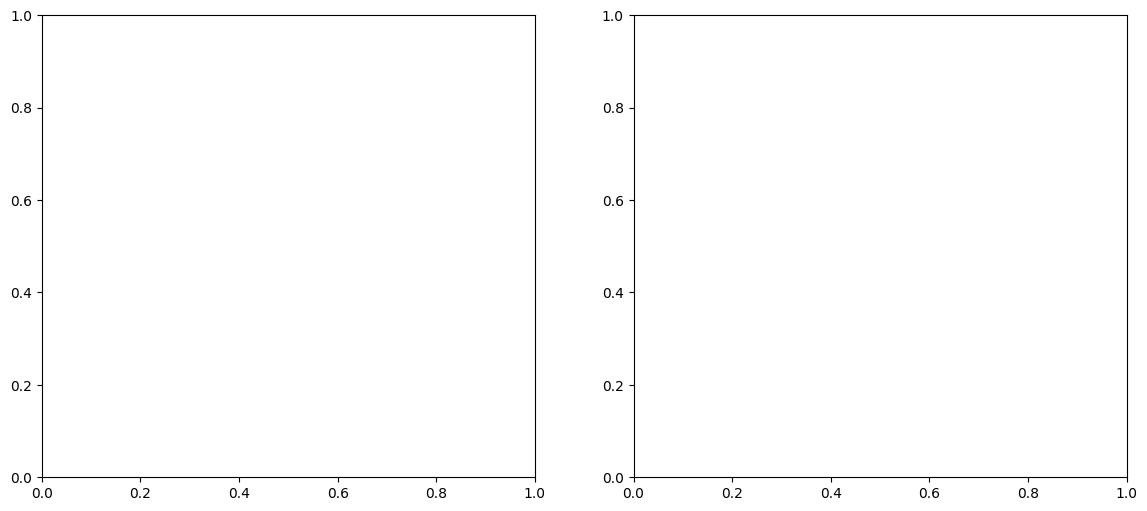

In [14]:
methods = [("baseline", 0), ("1G", 1), ("2G", 2), ("3G", 3), ("5G", 5), ("7G", 7), ("10G", 10)]
colors = cm.viridis(np.linspace(0., 0.95, len(methods)))
tasks = ["", "_signal_vs_bg"]
for task in tasks:
    if task == "":
        range_min = 0.4
        range_max = 0.9
    else:
        range_min = 0
        range_max = 1
    count = 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    for method, gauss in methods:
        sig = []
        bg = []
        # pred = evaluate_median_output(device=device, dir=method+task+"/", gauss_num=gauss)
        pred = evaluate_median_output_EPiC(device=device, dir=method+task+"/")
        for i in range(len(pred)):
            if pred[i,1]==1:
                sig.append(pred[i,0])
            else:
                bg.append(pred[i,0])
        sig = np.stack(sig)
        bg = np.stack(bg)
        ax1.hist(sig, label=method + " sig", bins=50, range=(range_min, range_max), histtype="step", stacked=True, color=colors[count])
        ax2.hist(bg, label=method + " bg", bins=50, range=(range_min, range_max), histtype="step", stacked=True, color=colors[count])
        count+=1
    ax1.set_xlabel("Prediction", fontsize=12)
    ax2.set_xlabel("Prediction", fontsize=12)
    ax1.set_ylabel("events", fontsize=12)
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    # ax1.set_xticks(fontsize=12)
    # ax2.set_xticks(fontsize=12)
    # ax1.set_yticks(fontsize=12)
    # ax2.set_yticks(fontsize=12)
    if task == "":
        ax1.legend(loc="upper right")
    else:
        ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()
    plt.close()

In [2]:
train = np.load("data/X_files/X_train_phi.npy")
label = np.load("data/X_files/y_train_phi.npy")
features = ["$m_{1}$ (TeV)", "$\\Delta m_J$ (TeV)", "$\\tau^{J_1}_{21}$", "$\\tau^{J_2}_{21}$", "$\\phi_{J_1}$"]

print(np.shape(label))

(196429, 2)


In [5]:
X_train = np.load("data/X_files_EPiC/X_train.npy")
y_train = np.load("data/X_files_EPiC/y_train.npy")
train_mask = (X_train[...,0] != 0.)
X_train = X_train[train_mask]

X_val = np.load("data/X_files_EPiC/X_val.npy")
y_val = np.load("data/X_files_EPiC/y_val.npy")
val_mask = (X_val[...,0] != 0.)
X_val = X_val[val_mask]

X_test = np.load("data/X_files_EPiC/X_test.npy")
y_test = np.load("data/X_files_EPiC/y_test.npy")
test_mask = (X_test[...,0] != 0.)
X_test = X_test[test_mask]

features = ["$p_T$ (GeV)", "$\\eta$", "$\\phi$"]

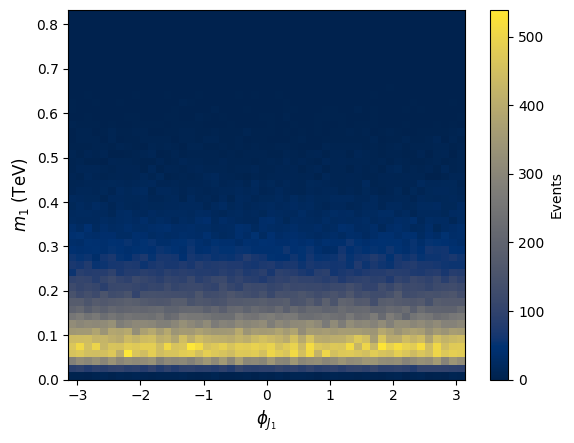

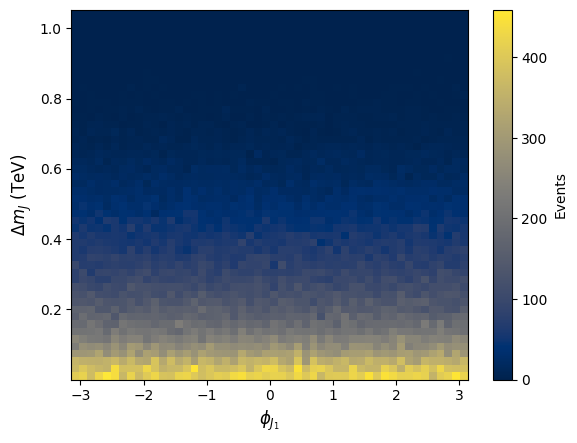

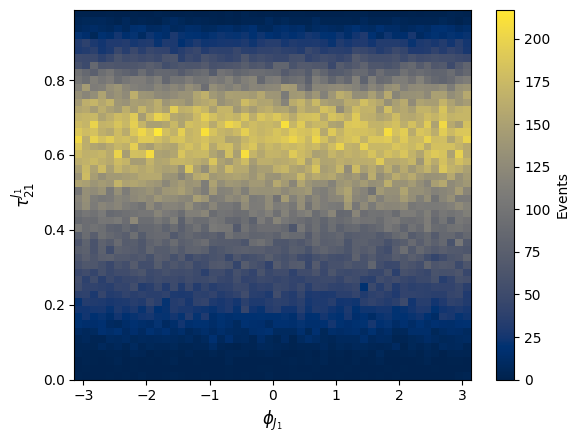

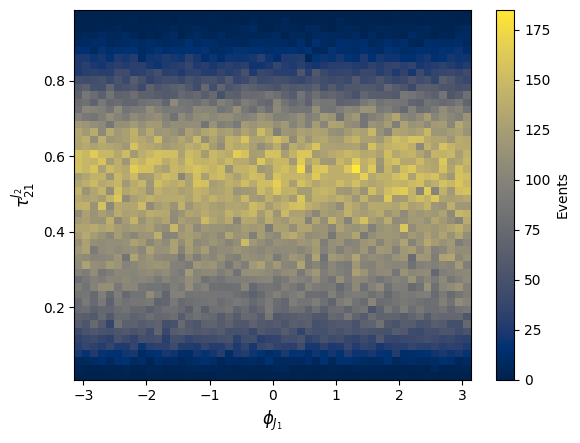

In [3]:
for fe in range(len(features)):
    fig, ax = plt.subplots()
    h = ax.hist2d(train[:, 4], train[:, fe], bins=50, cmap=cm.cividis)
    ax.set_xlabel("$\\phi_{J_1}$", fontsize=12)
    ax.set_ylabel(features[fe], fontsize=12)
    fig.colorbar(h[3], ax=ax, label ="Events", orientation="vertical")
    plt.show()
    plt.close()

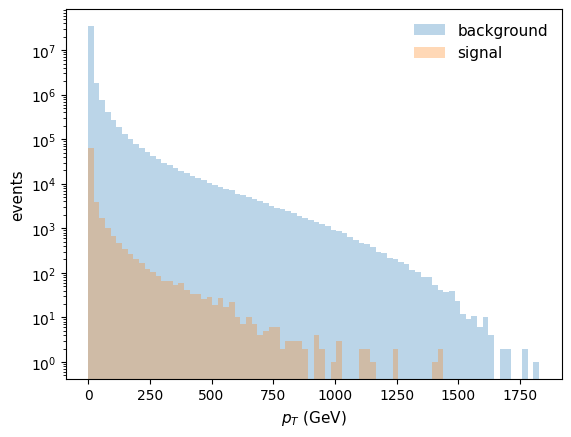

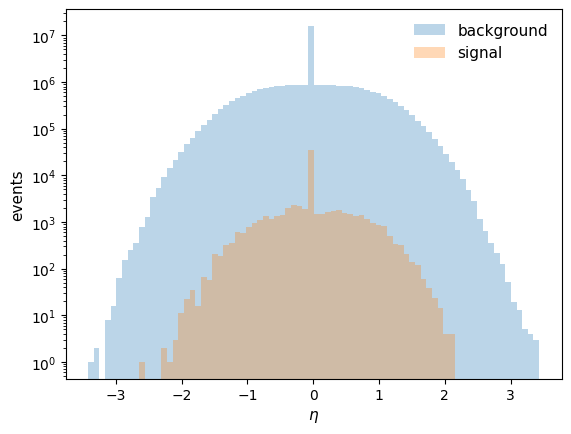

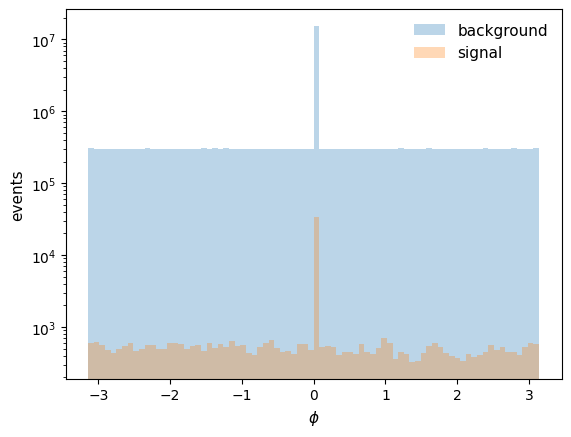

In [4]:
sig = []
bg = []
for i in range(len(y_train)):
    if y_train[i, 0] == 1:
        sig.append(X_train[i])
    else:
        bg.append(X_train[i])
sig = np.vstack(sig)
bg = np.vstack(bg)

for i in range(len(features)):
    kwargs = dict(histtype='stepfilled', alpha=0.3, bins=80)
    plt.hist(bg[..., i].flatten(), range = (bg[..., i].flatten().min(), bg[..., i].flatten().max()), label="background", **kwargs)
    plt.hist(sig[..., i].flatten(), range= (bg[..., i].flatten().min(), bg[..., i].flatten().max()), label="signal", **kwargs)
    plt.legend(loc = "upper right", frameon=False, fontsize=11)
    plt.xlabel(features[i], fontsize=11)
    plt.ylabel("events", fontsize=11)
    plt.yscale("log")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # plt.savefig("plots/results/feature"+str(i)+".png")
    plt.show()
    plt.close()